# PF Optimization: HRP vs Markowitz and Equal-Weighted Positions

## Imports & Settings

> This notebook requires the `conda` environment `backtest`. Please see the [installation instructions](../installation/README.md) for running the latest Docker image or alternative ways to set up your environment.

In [2]:
from time import time
import warnings
import sys

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web

from logbook import (NestedSetup, NullHandler, Logger, 
                     StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,get_datetime,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt import risk_models
from pypfopt import expected_returns

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [3]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [4]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

### Logging Setup

In [5]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stdout, format_string=format_string, level=WARNING),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## Algo Params

In [6]:
N_LONGS = 25
MIN_POSITIONS = 20

## Load Data

### Quandl Wiki Bundel

In [7]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [8]:
def load_predictions(bundle):
    path = Path('../../12_gradient_boosting_machines/data')
    predictions = (pd.read_hdf(path / 'predictions.h5', 'lgb/train/01')
                   .append(pd.read_hdf(path / 'predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))
    predictions = (predictions.loc[~predictions.index.duplicated()]
                   .iloc[:, :10]
                   .mean(1)
                   .sort_index()
                   .dropna()
                  .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [9]:
predictions, assets = load_predictions(bundle_data)

In [10]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2015-01-02 to 2017-12-28
Columns: 995 entries, 0 to 3188
dtypes: float64(995)
memory usage: 5.7 MB


### Define Custom Dataset

In [11]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [12]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [13]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [14]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0)
    },
            screen=StaticAssets(assets))

### Get daily Pipeline results

In [15]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')['longs'].astype(int)
    context.longs = output[output!=0].index
    if len(context.longs) < MIN_POSITIONS:
        context.divest = set(context.portfolio.positions.keys())
    else:
        context.divest = context.portfolio.positions.keys() - context.longs

## Define Rebalancing Logic

### Equal Weights

In [16]:
def rebalance_equal_weighted(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        for asset in context.longs:
            order_target_percent(asset, 1/len(context.longs))

### Markowitz Mean-Variance Optimization

In [56]:
def optimize_weights(prices, short=False):
    """Uses PyPortfolioOpt to optimize weights"""
    returns = expected_returns.mean_historical_return(prices=prices, 
                                                      frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)

    # get weights that maximize the Sharpe ratio
    # using solver SCS which produces slightly fewer errors than default
    # see https://github.com/robertmartin8/PyPortfolioOpt/issues/221
    ef = EfficientFrontier(expected_returns=returns, 
                           cov_matrix=cov, 
                           weight_bounds=(0, 1),
                           solver='SCS) 
    
    weights = ef.max_sharpe()
    if short:
        return {asset: -weight for asset, weight in ef.clean_weights().items()}
    else:
        return ef.clean_weights()

In [57]:
def rebalance_markowitz(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        prices = data.history(context.longs, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
        try:
            markowitz_weights = optimize_weights(prices)
            for asset, target in markowitz_weights.items():
                order_target_percent(asset=asset, target=target)
        except Exception as e:
            log.warn('{} {}'.format(get_datetime().date(), e))

### Hierarchical Risk Parity

In [58]:
def rebalance_hierarchical_risk_parity(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    Uses PyPortfolioOpt to optimize weights
    """
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    for asset in context.divest:
        order_target(asset, target=0)
        
    if len(context.longs) > context.min_positions:
        returns = (data.history(context.longs, fields='price',
                          bar_count=252+1, # for 1 year of returns 
                          frequency='1d')
                   .pct_change()
                   .dropna(how='all'))
        hrp_weights = HRPOpt(returns=returns).optimize()
        for asset, target in hrp_weights.items():
            order_target_percent(asset=asset, target=target)

## Record Additional Data Points

Define addtional variables to capture in the results `DataFrame`.

In [59]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs)

## Initialize Algorithm with PF optimization algorithm

Execute `run_algorithm` once with each algorithm:

### Select portfolio optimization algorithm

In [60]:
pf_algos = {
    'ew': rebalance_equal_weighted,
    'markowitz': rebalance_markowitz,        
    'hrp': rebalance_hierarchical_risk_parity
}


In [61]:
# more descriptive labels for plots
algo_labels = {
    'ew': 'Equal Weighted', 
    'markowitz': 'Markowitz (MFT)',
    'hrp': 'Hierarchical Risk Parity'
    }

Here we set the algo we are going to use:

In [69]:
selected_pf_algo = 'hrp'

### Schedule rebalancing using selected algo

In [70]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = 0
    context.pf_algo = pf_algos.get(selected_pf_algo)
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=1))

    schedule_function(context.pf_algo,
                      # run every day after market open
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))    

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

## Run trading algorithm for each PF optimization approach

In [71]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [72]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2015-01-02
End:   2017-12-28


In [73]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[ 18:22:16.112701]: INFO: after split: asset: Equity(406 [BOFI]), amount: 208, cost_basis: 21.58, last_sale_price: 83.29
[ 18:22:16.113149]: INFO: returning cash: 0.0
[ 18:23:15.358703]: INFO: Simulated 754 trading days
first open: 2015-01-02 14:31:00+00:00
last close: 2017-12-28 21:00:00+00:00
Duration: 82.44s


### Persist experiment results

In [74]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [75]:
with pd.HDFStore('backtests.h5') as store:
    store.put('returns/{}'.format(selected_pf_algo), returns)
    store.put('positions/{}'.format(selected_pf_algo), positions)
    store.put('transactions/{}'.format(selected_pf_algo), transactions)

In [76]:
with pd.HDFStore('backtests.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: backtests.h5
/positions/ew                      frame        (shape->[700,1])  
/positions/hrp                     frame        (shape->[700,1])  
/positions/markowitz               frame        (shape->[691,1])  
/returns/ew                        series       (shape->[754])    
/returns/hrp                       series       (shape->[754])    
/returns/markowitz                 series       (shape->[754])    
/transactions/ew                   frame        (shape->[24443,8])
/transactions/hrp                  frame        (shape->[25332,8])
/transactions/markowitz            frame        (shape->[4489,8]) 


## Comparing results using pyfolio

Once you're run the three algorithms (or those you're interested in), let's compare the results.

### Load benchmark

In [77]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Cumulative Returns & Rolling Sharpe Ratios

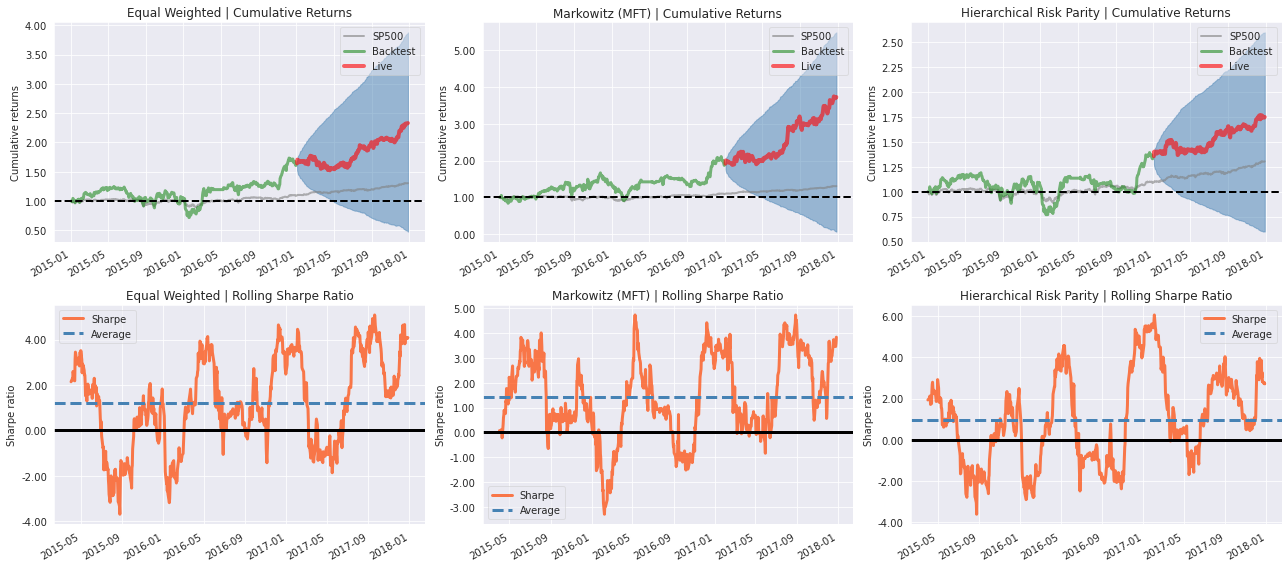

In [78]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 8))

for i, (algo, label) in enumerate(algo_labels.items()):
    returns = pd.read_hdf('backtests.h5', f'returns/{algo}')    
    plot_rolling_returns(returns,
                         factor_returns=benchmark,
                         live_start_date='2017-01-01',
                         logy=False,
                         cone_std=2,
                         legend_loc='best',
                         volatility_match=False,
                         cone_function=forecast_cone_bootstrap,
                        ax=axes[0][i])
    plot_rolling_sharpe(returns, ax=axes[1][i], rolling_window=63)
    axes[0][i].set_title(f'{label} | Cumulative Returns')
    axes[1][i].set_title(f'{label} | Rolling Sharpe Ratio')
    fig.tight_layout()

### Tear Sheets

In [79]:
def load_results(experiment='hrp'):
    with pd.HDFStore('backtests.h5') as store:
        returns = store.get('returns/{}'.format(experiment))
        positions = store.get('positions/{}'.format(experiment))
        transactions = store.get('transactions/{}'.format(experiment))
    return returns, positions, transactions

#### Equal Weighted

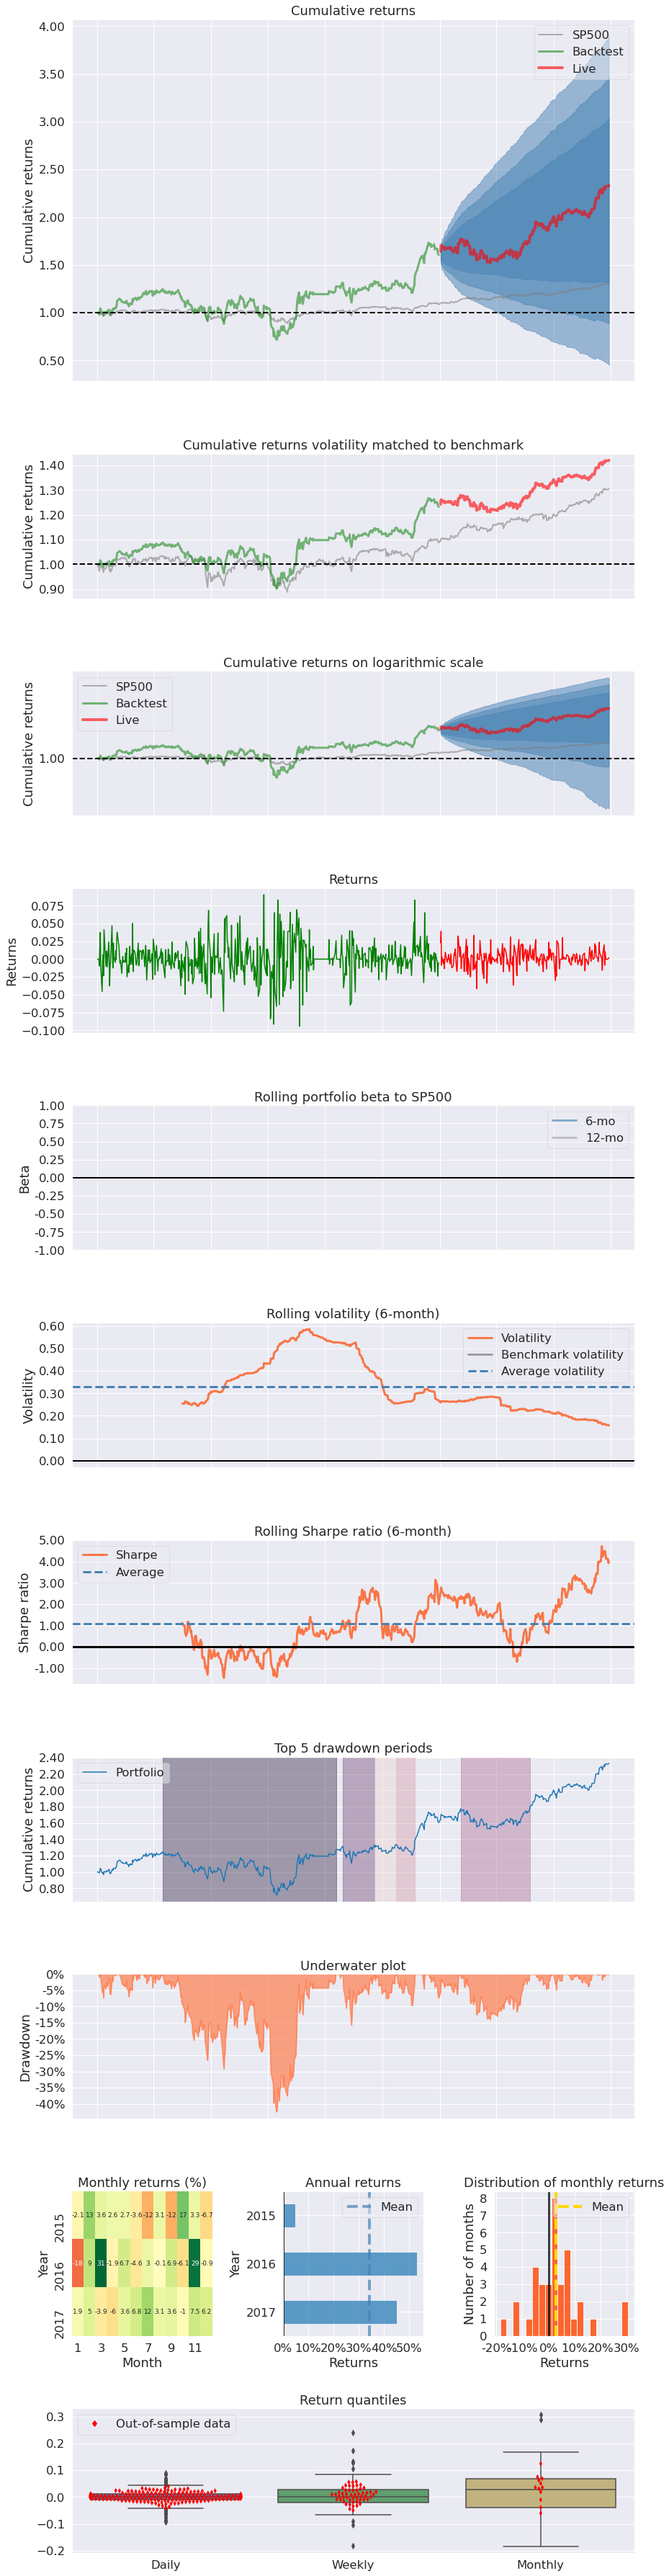

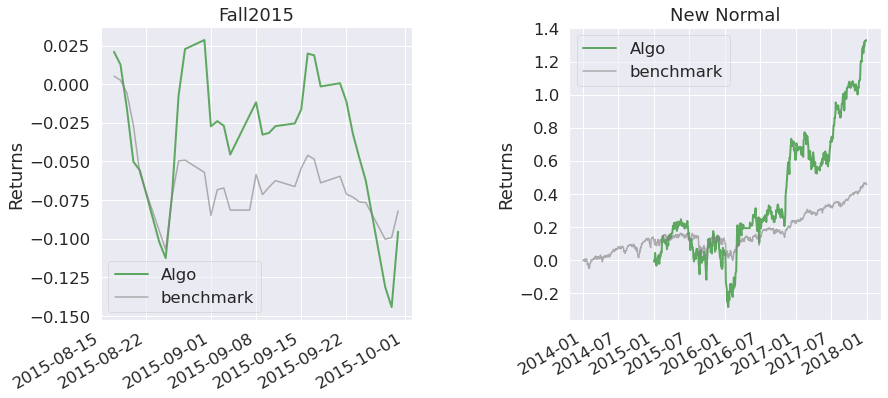

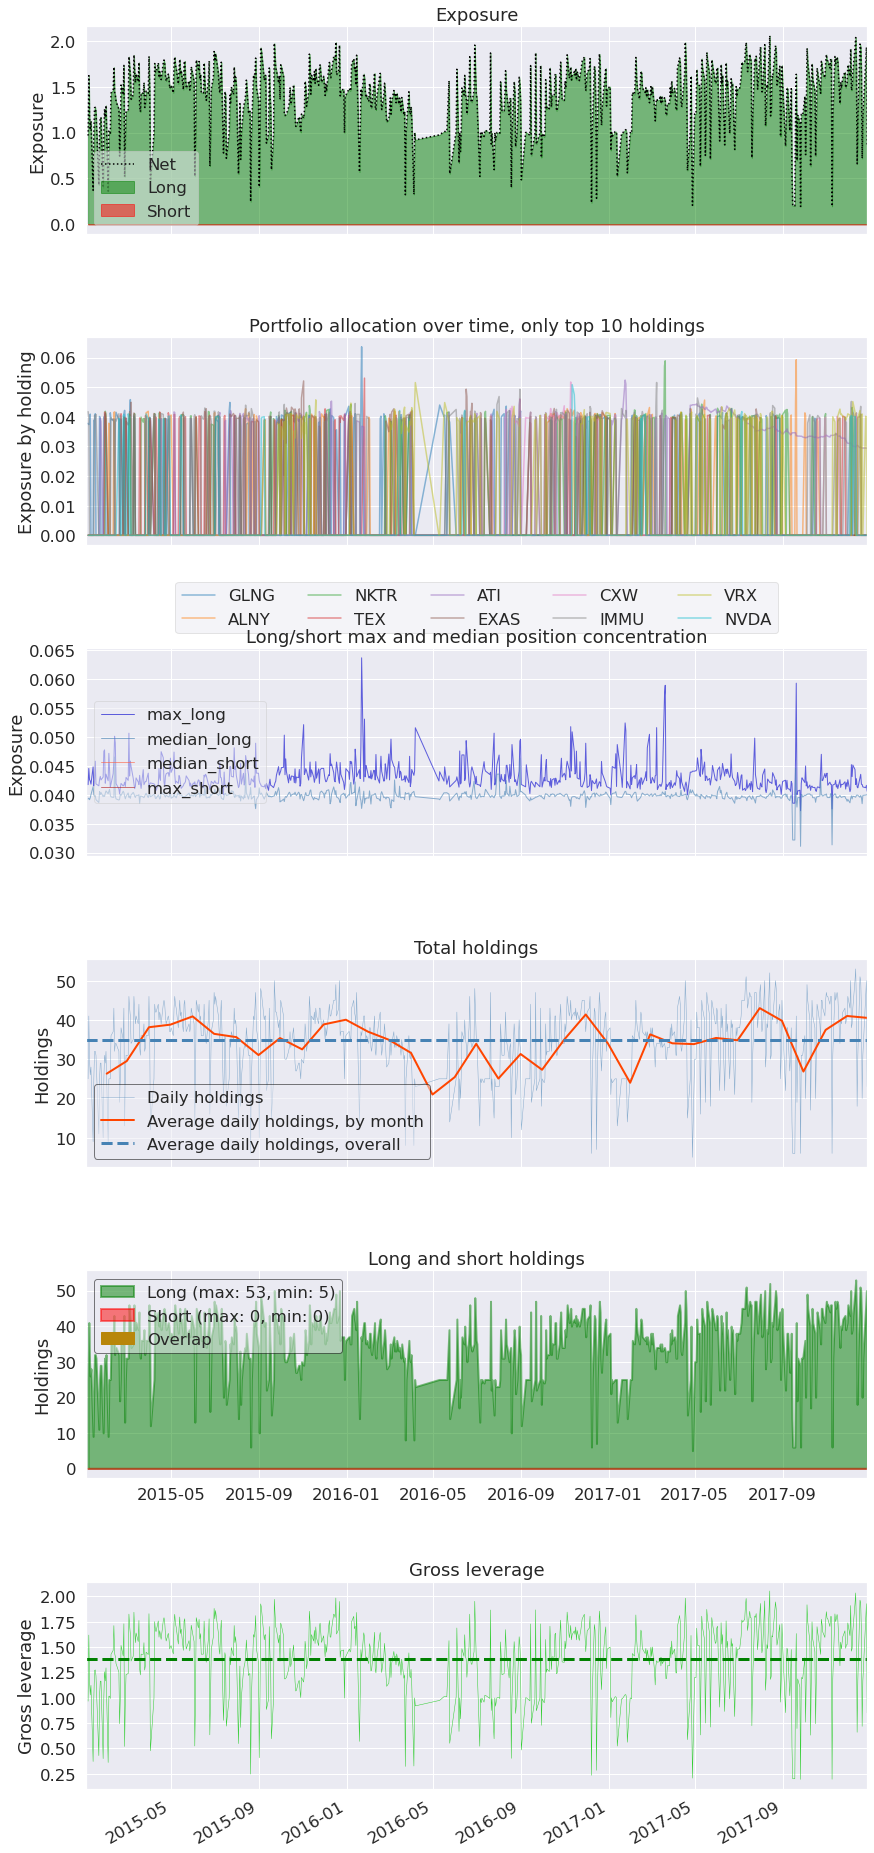

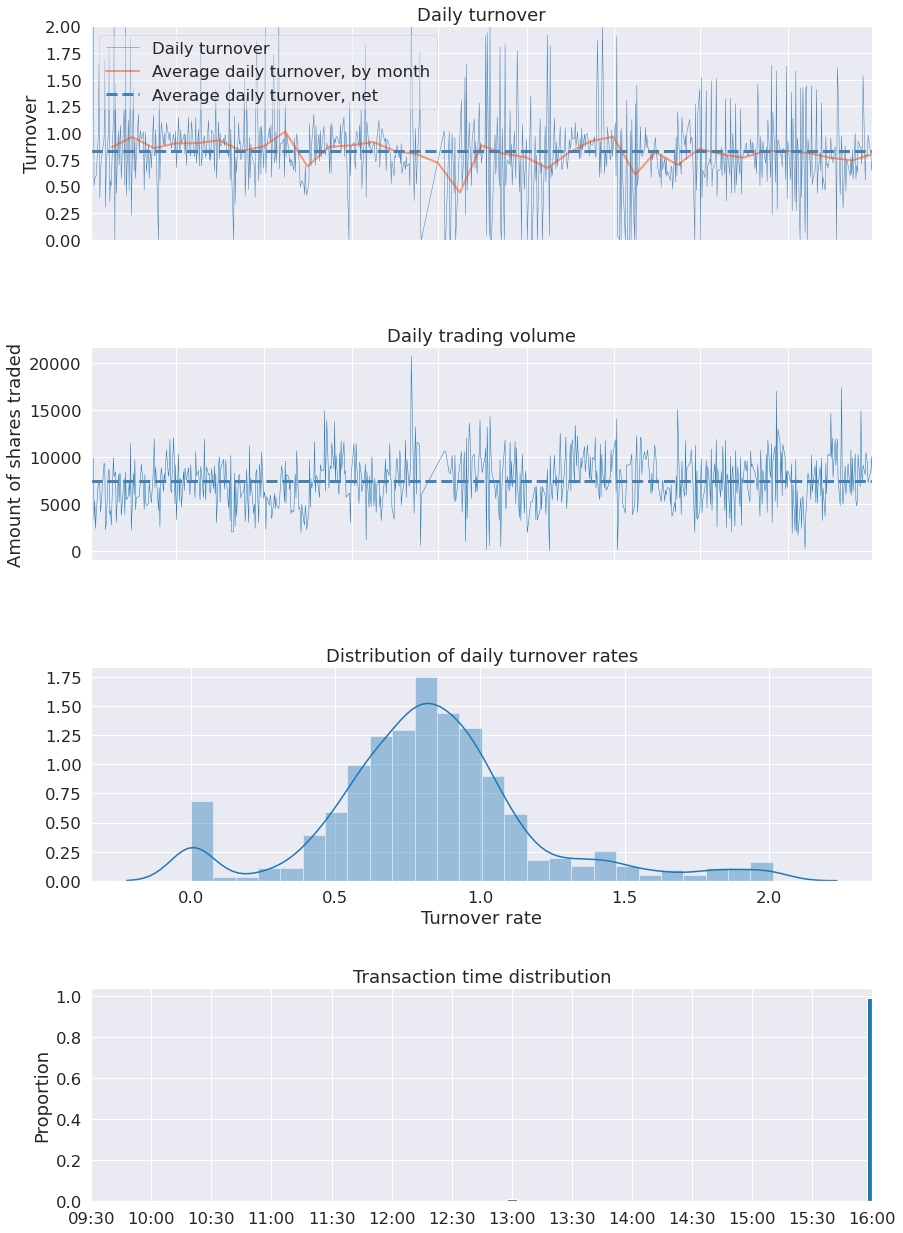

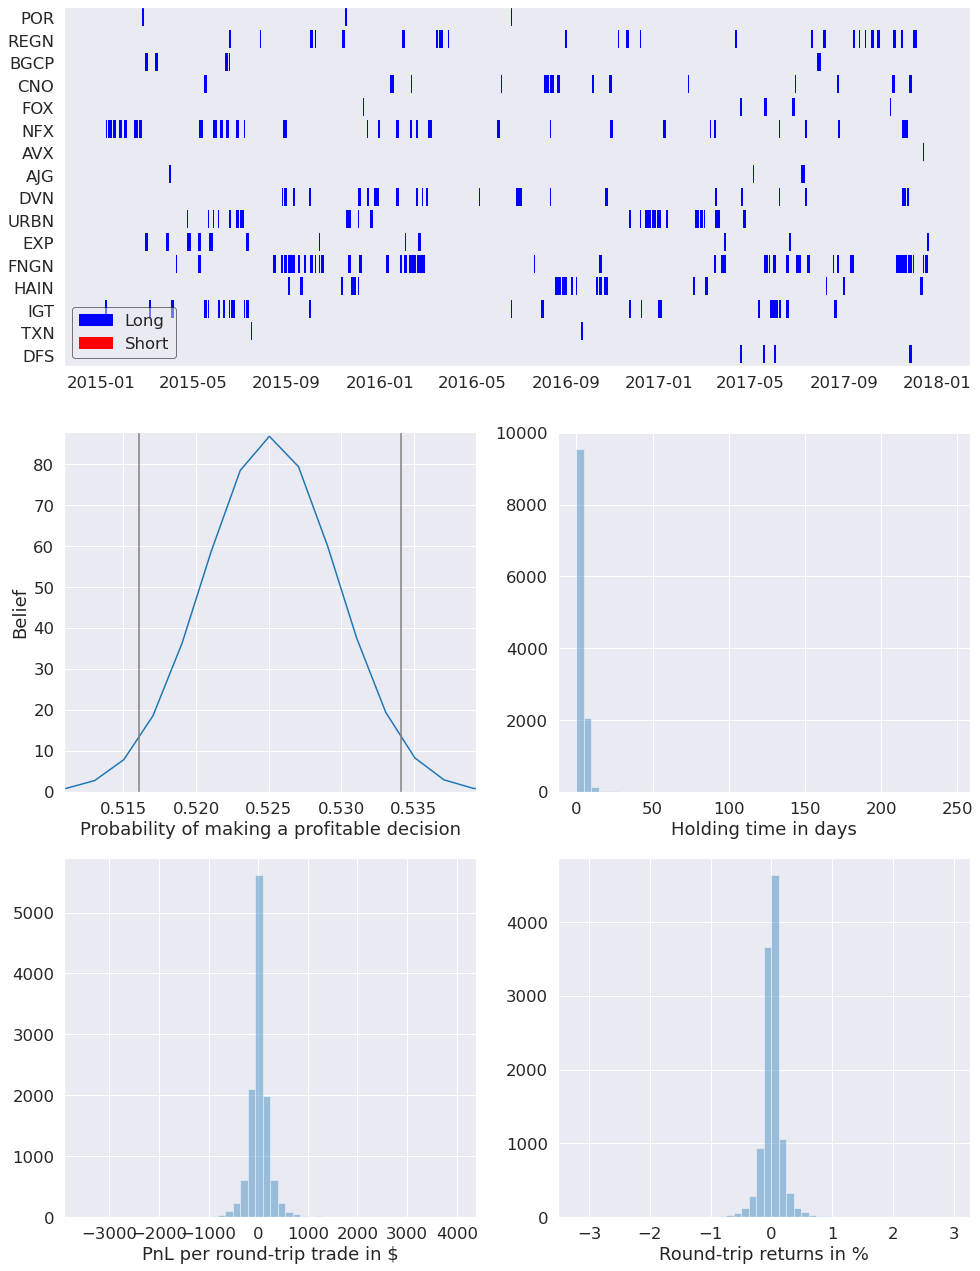

In [80]:
experiment = 'ew'
returns, positions, transactions = load_results(experiment)

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)

#### HRP

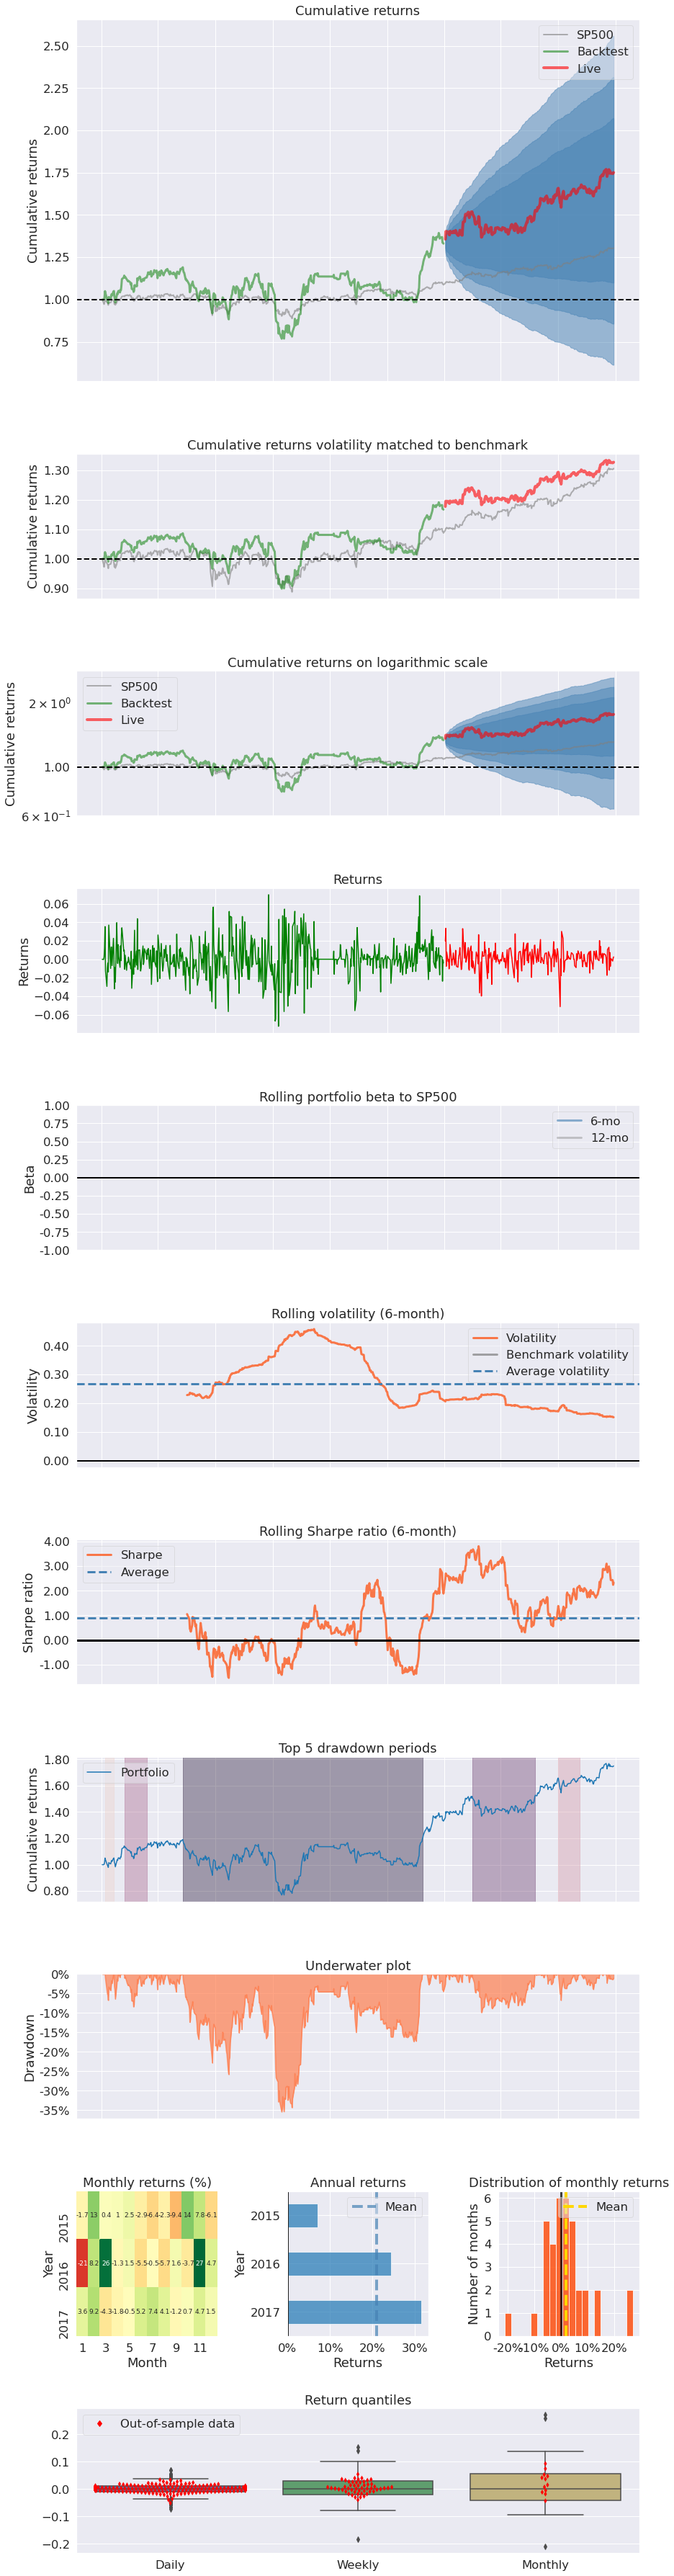

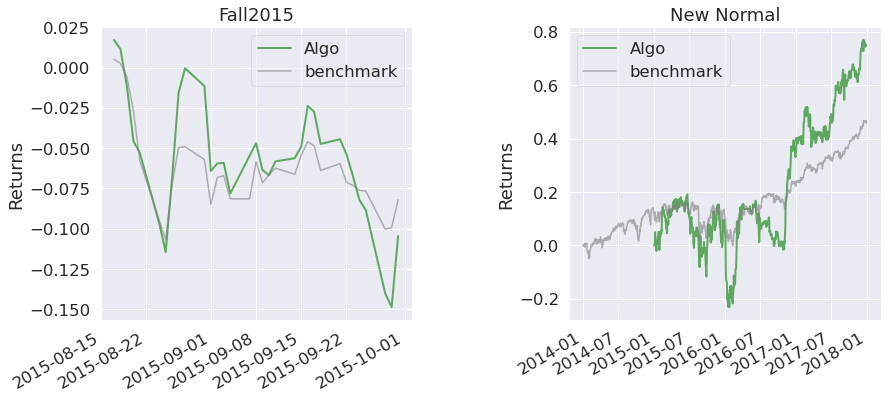

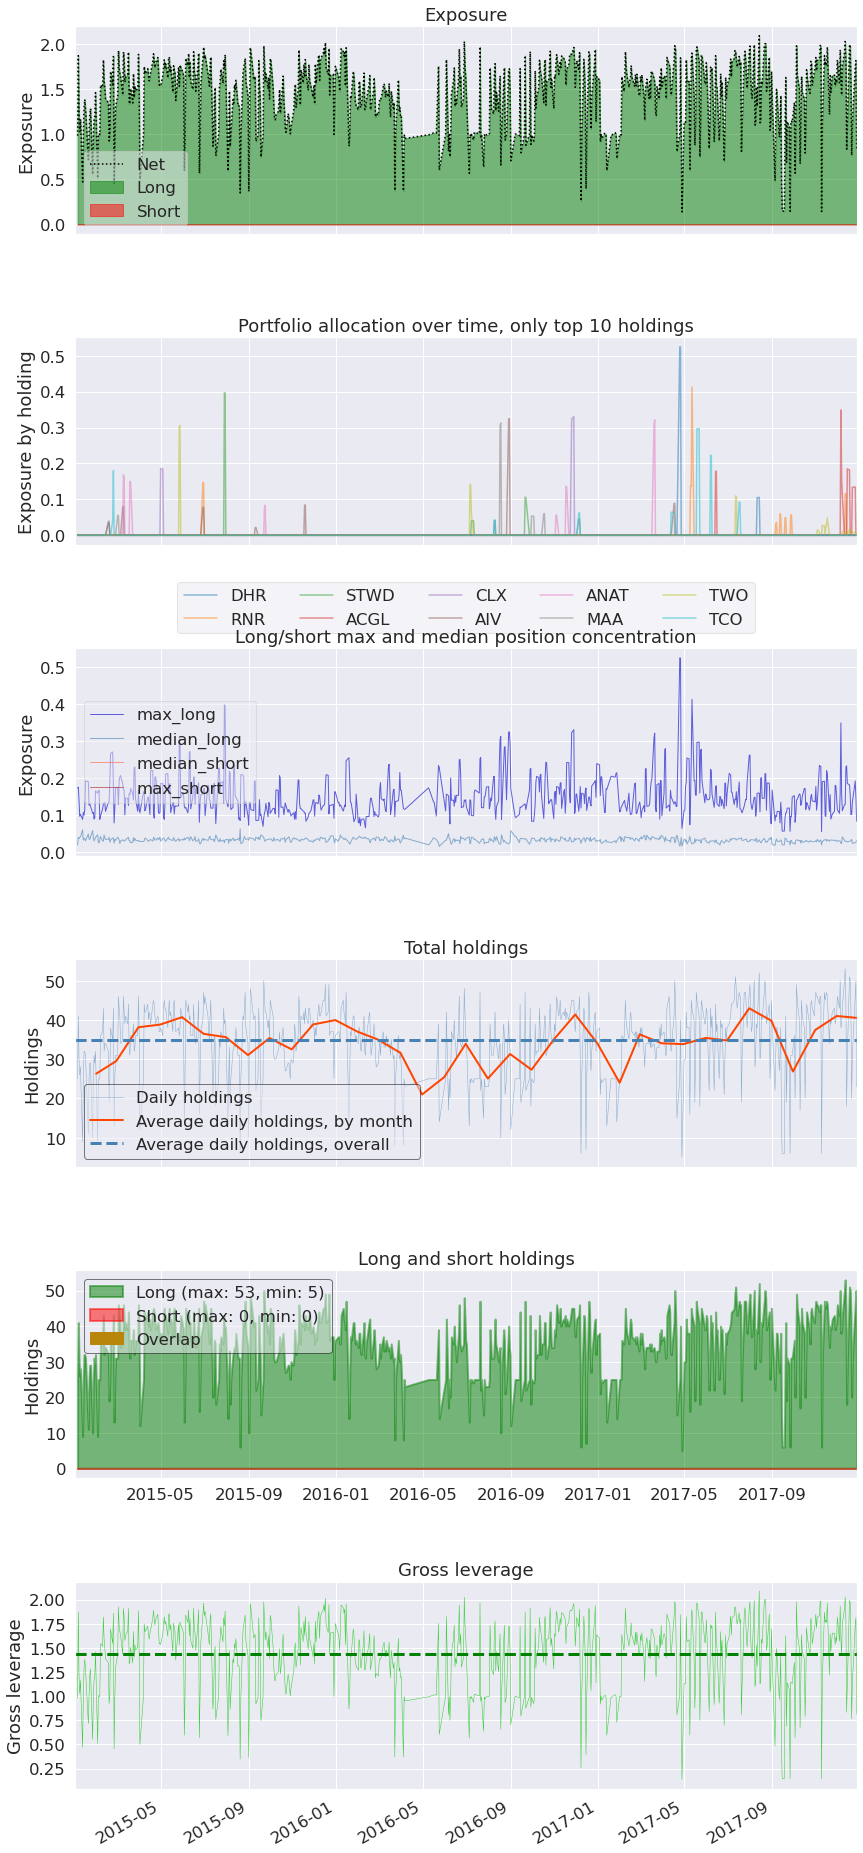

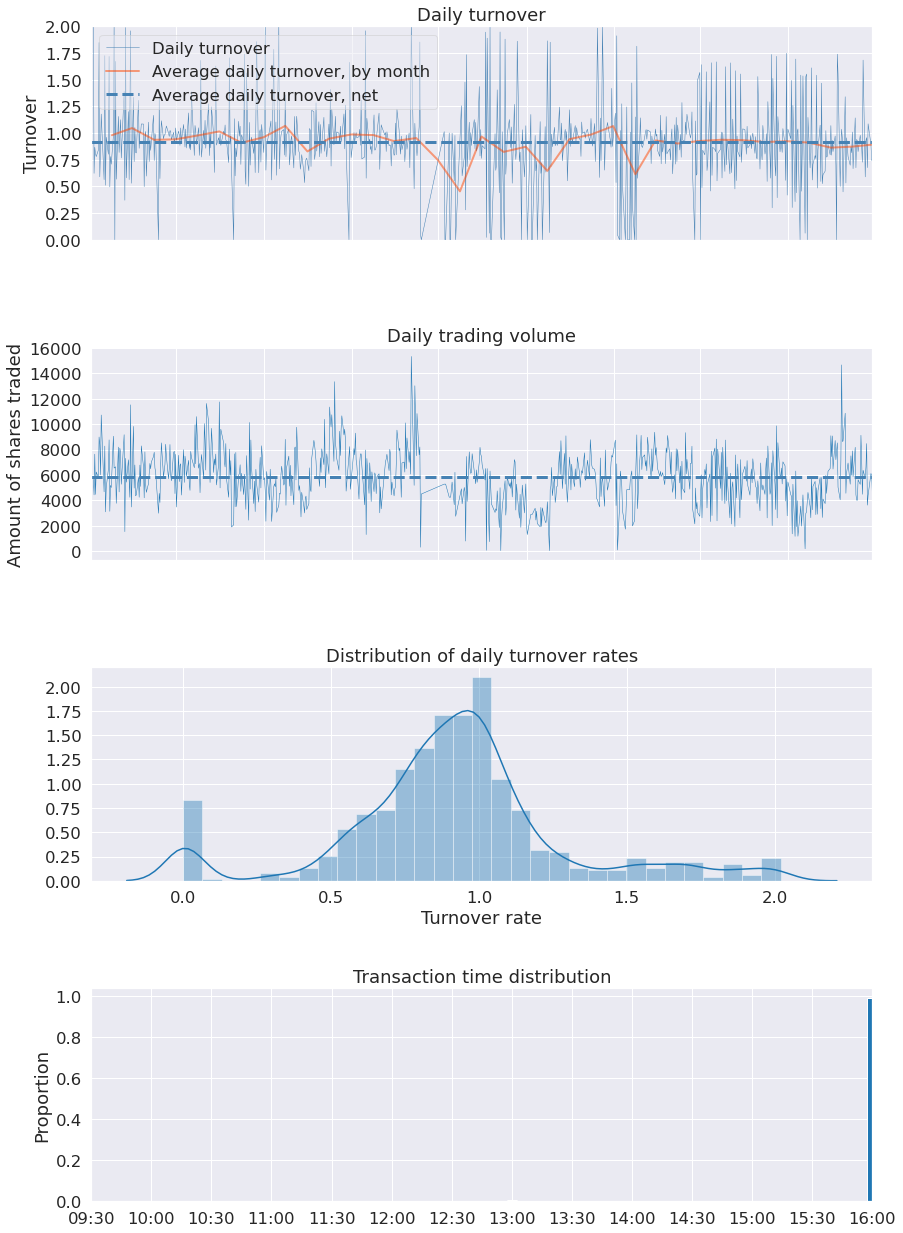

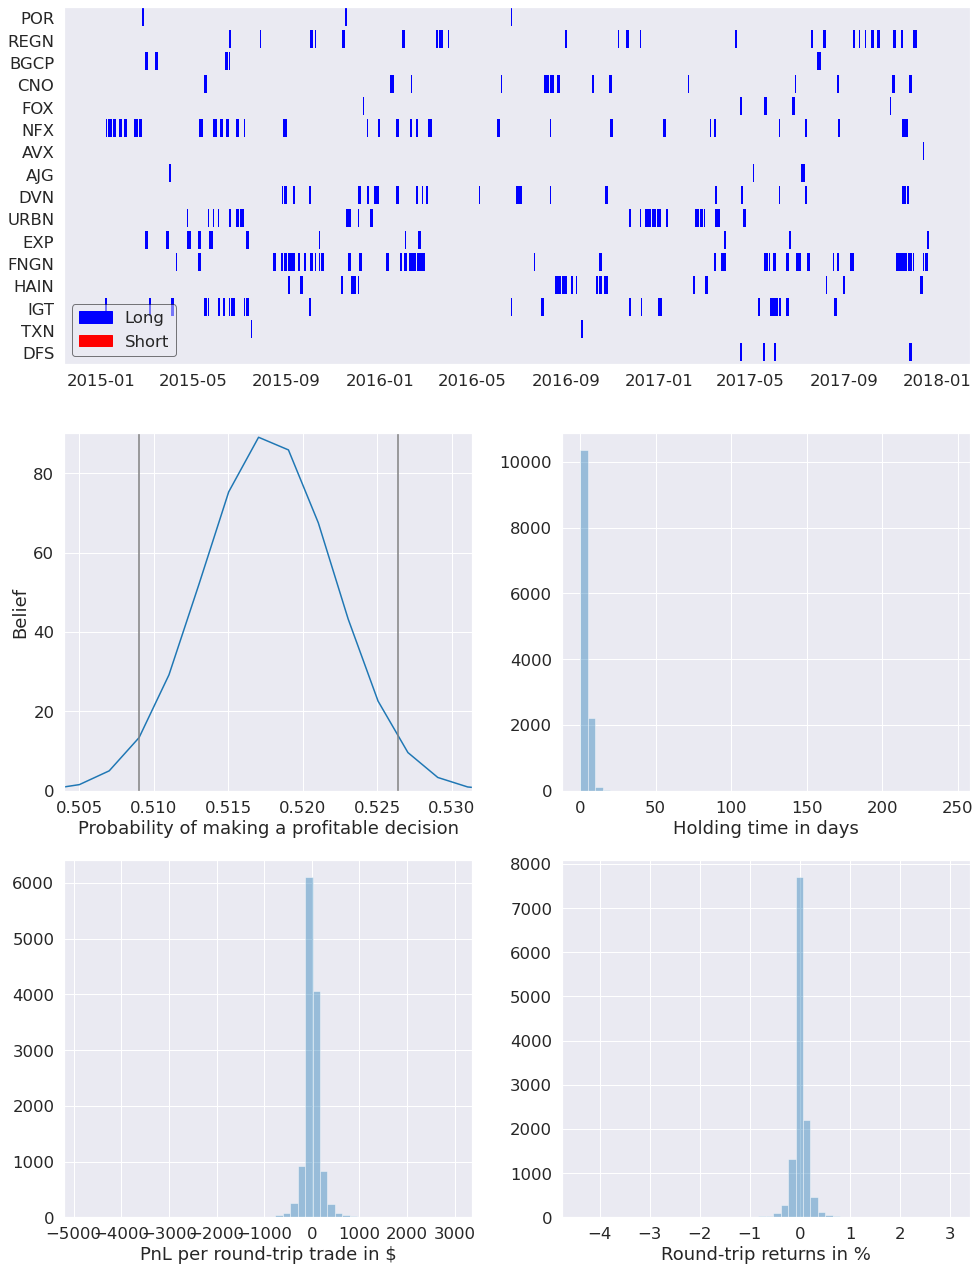

In [81]:
experiment = 'hrp'
returns, positions, transactions = load_results(experiment)

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)

#### Markowitz

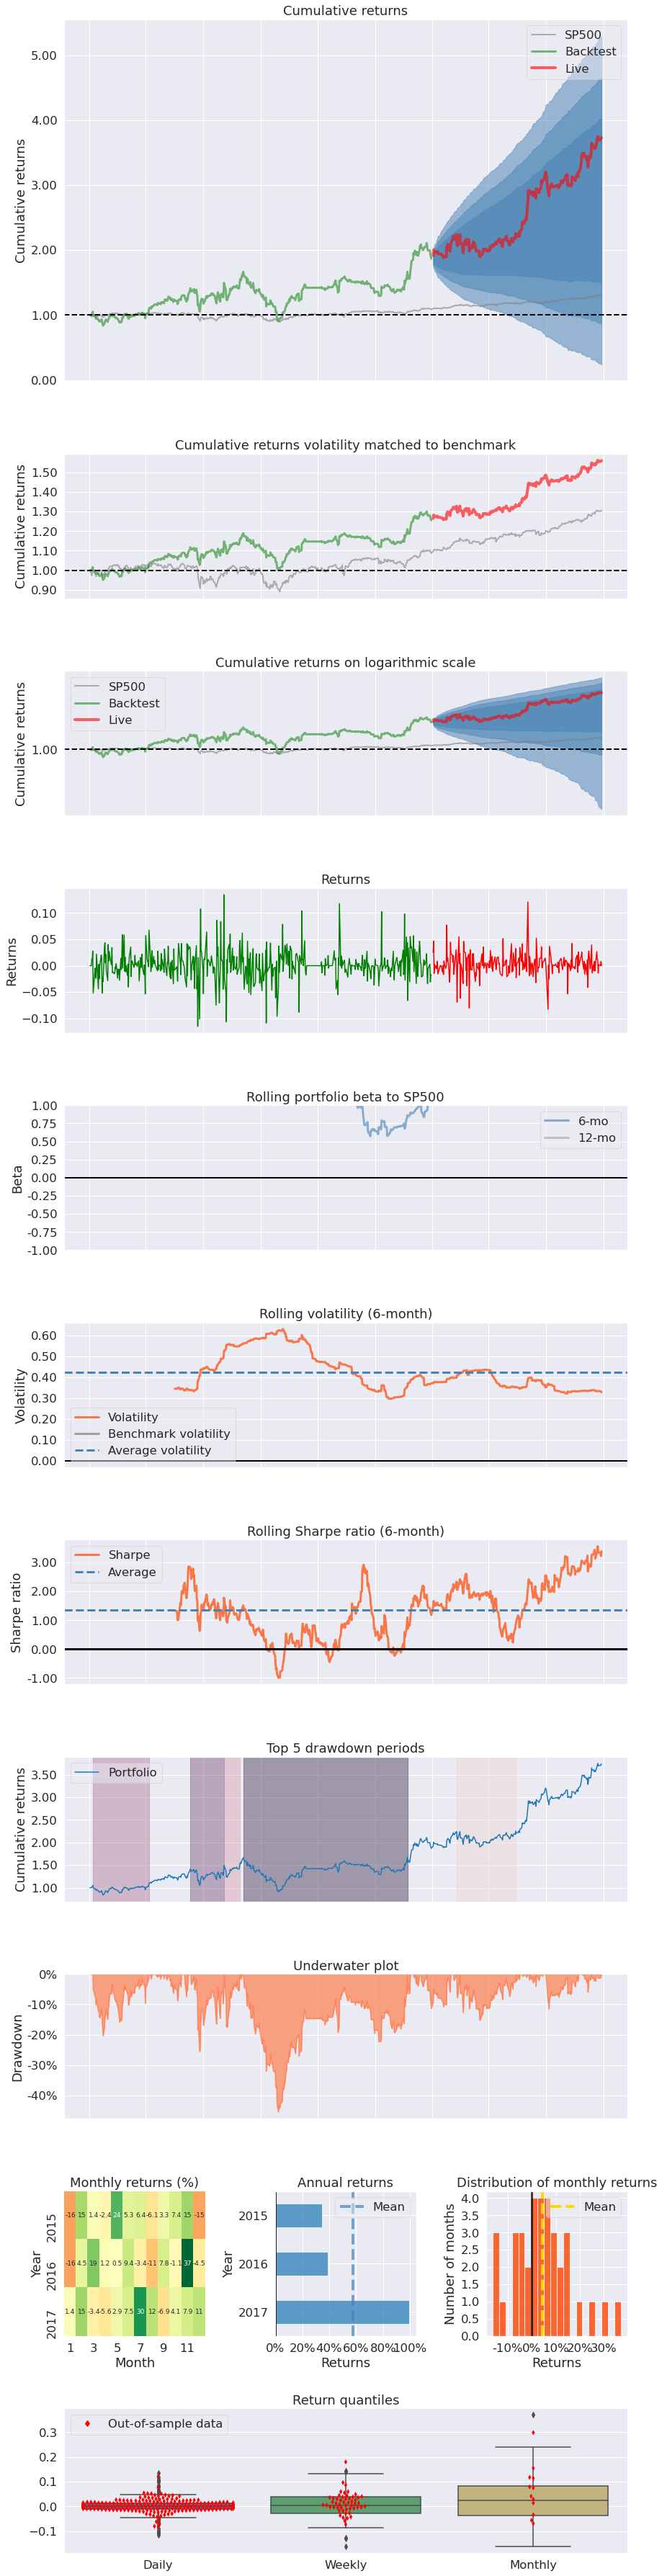

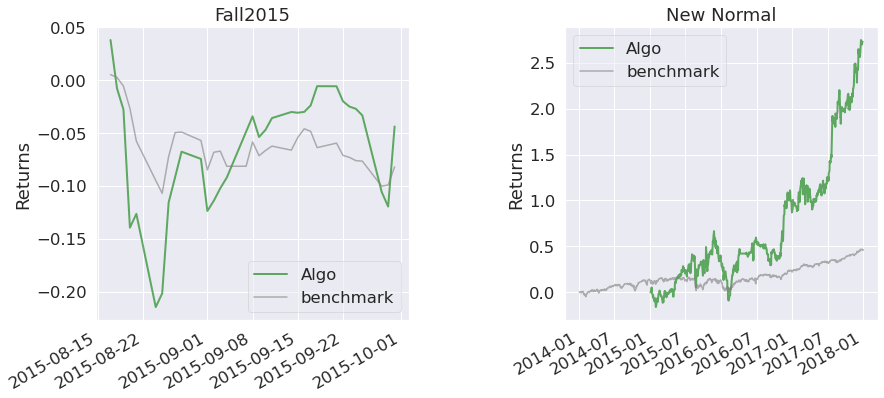

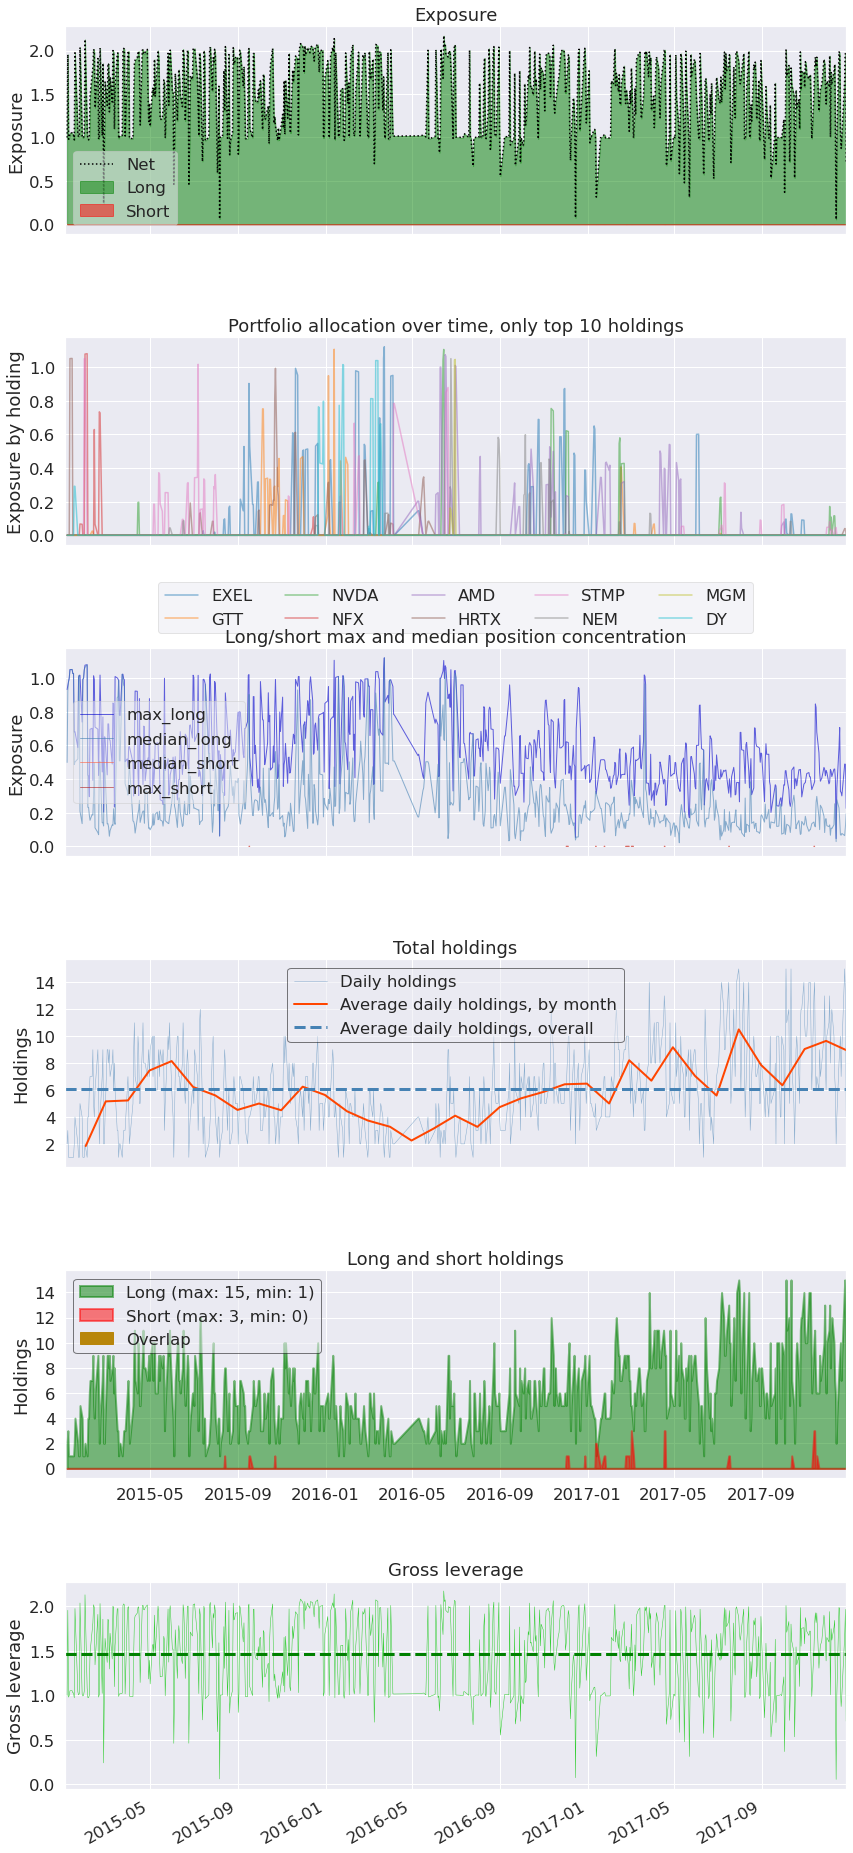

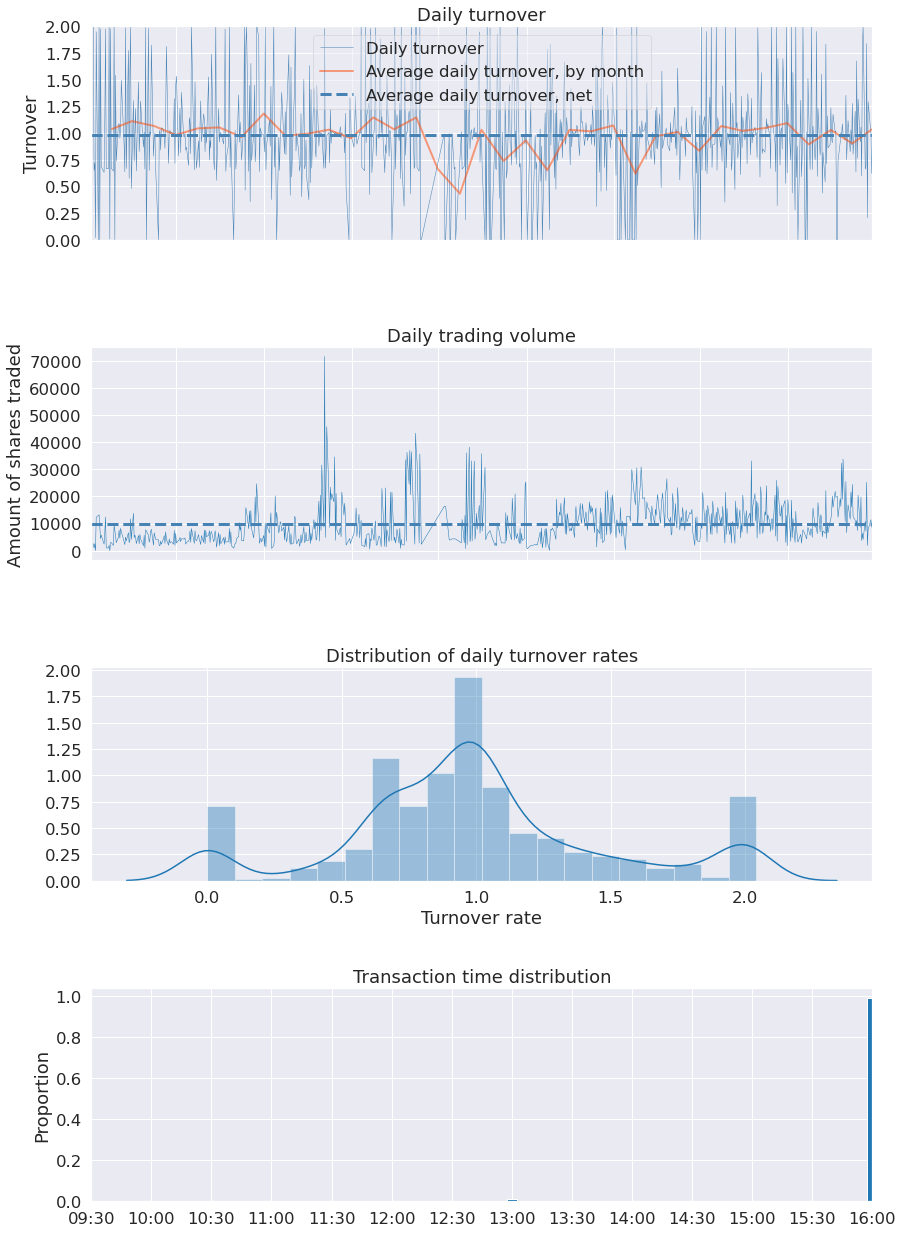

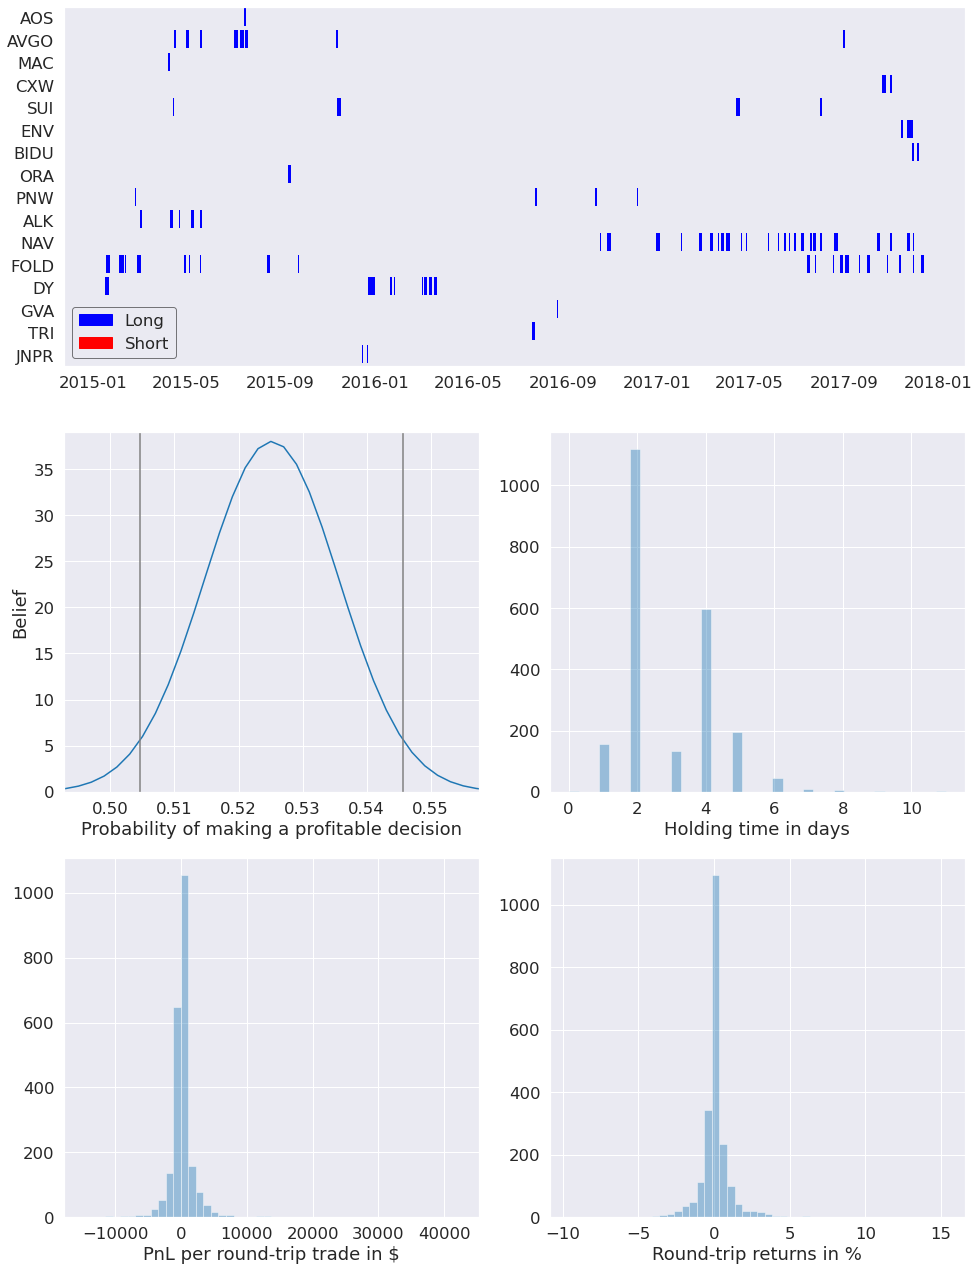

In [82]:
experiment = 'markowitz'
returns, positions, transactions = load_results(experiment)

pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)